<a href="https://colab.research.google.com/github/PiyushLodhi/deeplearning/blob/master/planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.4)


In [0]:
from  fastai import *
from fastai.vision import * 
import numpy as np

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [0]:
path=Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path


PosixPath('/root/.fastai/data/planet')

In [0]:
 ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
 ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
 ! unzip -q -n {path}/train_v2.csv.zip -d {path}

 98% 591M/600M [00:08<00:00, 63.7MB/s]
100% 600M/600M [00:08<00:00, 77.3MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 60.1MB/s]


In [0]:
path=Config.data_path()/'planet' 

In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)


In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))


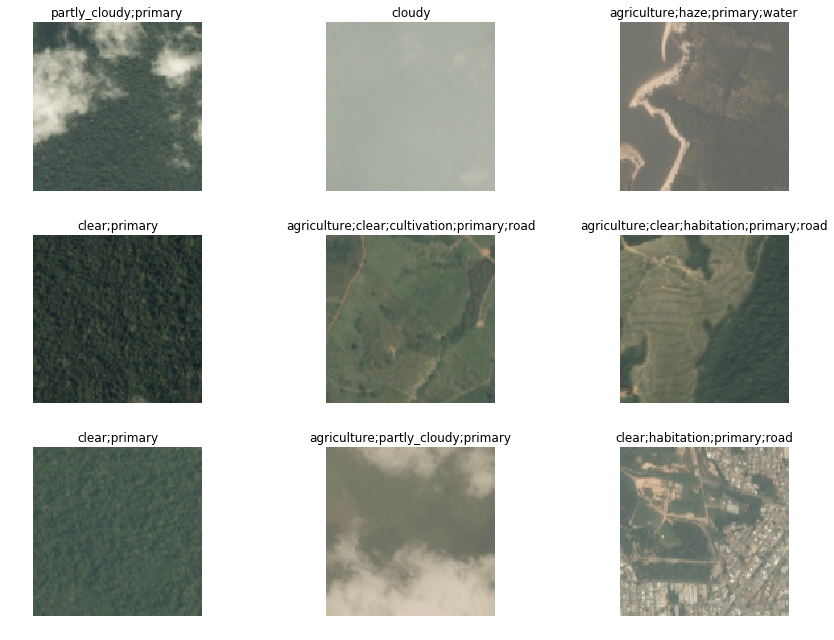

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch  = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 160447713.37it/s]


In [0]:

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


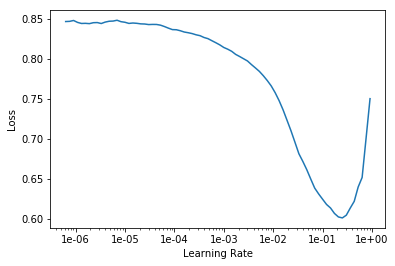

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(52, slice(.01))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.138887,0.119210,0.943713,0.896889,02:26
1,0.121681,0.109306,0.947099,0.904869,02:24
2,0.114238,0.103071,0.947607,0.908015,02:23
3,0.109643,0.098768,0.950289,0.913961,02:22
4,0.104291,0.095508,0.951967,0.916328,02:23
5,0.103814,0.096005,0.949940,0.913283,02:23
6,0.102163,0.091761,0.947767,0.919102,02:21
7,0.103347,0.090091,0.955368,0.922175,02:21
8,0.098634,0.091590,0.956938,0.918264,02:20
9,0.099765,0.088529,0.951706,0.924192,02:21


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save('stage-1-rn50')


In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [41]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


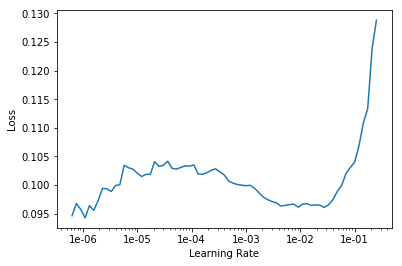

In [43]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3,5e-04)

In [0]:
learn.save('stage-2')